In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
 
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import sys

E:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_data = np.loadtxt(r"C:\Users\Arnold\Desktop\4560\practice\0 dataset midi\0 x_data_n_1024.txt",
                   delimiter=',')
y_data = np.loadtxt(r"C:\Users\Arnold\Desktop\4560\practice\0 dataset midi\0 y_data_n_1024.txt",
                   delimiter=',')

while x_data.shape[0] % 100 !=0:
    x_data = np.delete(x_data, -1, 0)
    y_data = np.delete(y_data, -1, 0)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.14285, random_state=42)
x_train = x_train.astype('float32') / 127.
x_test = x_test.astype('float32') / 127.

In [28]:
saveout = sys.stdout
file = open('variational_autoencoder.txt','w')
sys.stdout = file
 
batch_size = 20
original_dim = 1024   #32*32
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
# epsilon_std = 1.0
epsilon_std = 1.0

In [29]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [30]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
 
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [31]:
#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [32]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
 

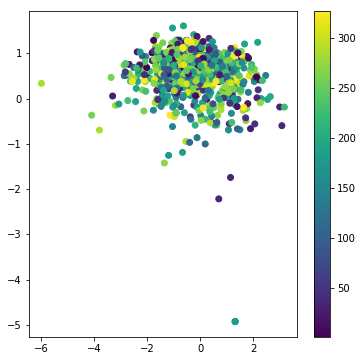

In [33]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
 

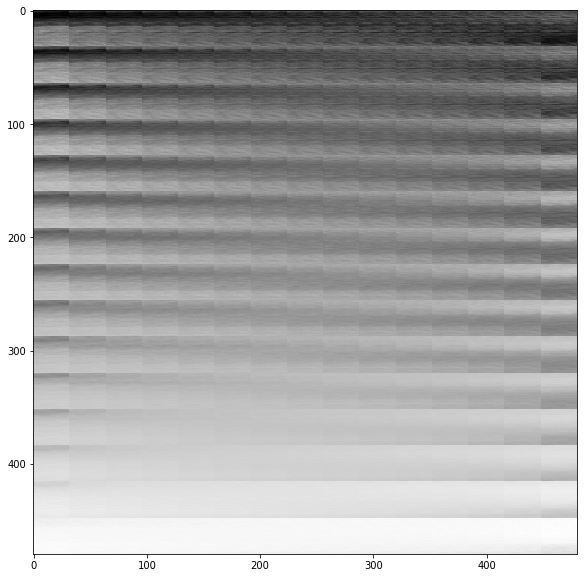

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        print(xi,yi)
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
 
plot_model(vae,to_file='variational_autoencoder_vae.png',show_shapes=True)
plot_model(encoder,to_file='variational_autoencoder_encoder.png',show_shapes=True)
plot_model(generator,to_file='variational_autoencoder_generator.png',show_shapes=True)
 
sys.stdout.close()
sys.stdout = saveout

In [ ]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print(grid_x)

sample = generator.predict(np.array([[grid_x[5],grid_y[13]]]))
print(sample)

In [ ]:
import datetime
import os
nowTime = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
dir = r"C:\Users\Arnold\Desktop\4560\practice\B build VAE"
np.savetxt(os.path.join(dir,"sample"+'_'+str(nowTime)+'.txt'),
           sample*127,fmt='%d',delimiter=',')
np.savetxt(os.path.join(dir,"sample.txt"),
           sample*127,fmt='%d',delimiter=',')